# Multi-Class Classification with Perceptron

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

You can use the following perceptron training code from the lecture:

In [2]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [3]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

NameError: name 'wts' is not defined

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [9]:
!rm *.pkl
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
!gzip -d mnist.pkl.gz

rm: cannot remove '*.pkl': No such file or directory


--2025-07-15 05:19:10--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.07s   

2025-07-15 05:19:10 (223 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]



In [11]:
!ls

mnist.pkl


In [6]:
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle, encoding='latin1')

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


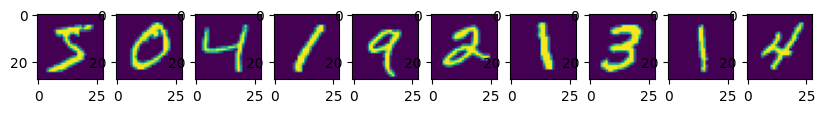

In [ ]:
training_data, validation_data, test_data = MNIST

train_features = training_data[0]  
train_labels = training_data[1]   

print(train_features[0][130:180]) 
print(train_labels[0])          

features = train_features.astype(np.float32) / 255.0
labels = train_labels

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    plt.imshow(features[i].reshape(28,28))
plt.show()

Code to create *one-vs-other* dataset for two-digit classification. You need to modify this code to create *one-vs-all* dateset.

In [20]:
def set_mnist_pos_neg(positive_label, negative_label, mnist_data):
    training_data = mnist_data[0]
    train_features = training_data[0]
    train_labels = training_data[1]
    
    positive_indices = [i for i, j in enumerate(train_labels) if j == positive_label]
    negative_indices = [i for i, j in enumerate(train_labels) if j == negative_label]
    
    positive_images = train_features[positive_indices]
    negative_images = train_features[negative_indices]
    
    
    return positive_images, negative_images

Now you need to:
1. Create 10 *one-vs-all* datasets for all digits
1. Train 10 perceptrons
1. Define `classify` function to perform digit classification
1. Measure the accuracy of classification and print *confusion matrix*
1. [Optional] Create improved `classify` function that performs the classification using one matrix multiplication.

In [ ]:
import random
import sklearn
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import PCA

class PerceptronMultiClass:
    def __init__(self, training_data, apply_pca=False, n_components=2):
        self.training_data = training_data
        self.apply_pca = apply_pca
        self.pca = None
        self.n_components = n_components
        self.all_vs_all_dataset = [self.create_all_vs_all(i, training_data) for i in range(10)]
        self.weights = [np.zeros((self.all_vs_all_dataset[0][0].shape[1], 1)) for _ in range(10)]

    def apply_pca_transform(self, features):
        if self.apply_pca and self.pca is not None:
            return self.pca.transform(features)
        return features

    def create_all_vs_all(self, digit, training_data, apply_pca=False, n_components=2):
        train_features = training_data[0]
        train_labels = training_data[1]
        positive_indices = [i for i, j in enumerate(train_labels) if j == digit]
        negative_indices = [i for i, j in enumerate(train_labels) if j != digit]
        positive_images = train_features[positive_indices]

        negative_images = train_features[negative_indices]
        if self.apply_pca:
            self.pca = PCA(n_components=self.n_components)
            self.pca.fit(train_features)
            return self.apply_pca_transform(positive_images), self.apply_pca_transform(negative_images)
        else:
            return positive_images, negative_images
        

    def train(self, num_iterations=1000, report_frequency=10):
        for digit in range(10):
            positive_examples, negative_examples = self.all_vs_all_dataset[digit]
            weights = np.zeros((positive_examples.shape[1], 1))
            pos_count = positive_examples.shape[0]
            neg_count = negative_examples.shape[0]
            for i in range(num_iterations):
                pos = random.choice(positive_examples)
                neg = random.choice(negative_examples)
                z = np.dot(pos, weights)
                if z < 0: 
                    weights = weights + pos.reshape(weights.shape)
                z = np.dot(neg, weights)
                if z >= 0: 
                    weights = weights - neg.reshape(weights.shape)
                if i % report_frequency == 0:
                    pos_out = np.dot(positive_examples, weights)
                    neg_out = np.dot(negative_examples, weights)
                    pos_correct = (pos_out >= 0).sum() / float(pos_count)
                    neg_correct = (neg_out < 0).sum() / float(neg_count)
                    print(f"Digit={digit}, Iteration={i}, pos correct={pos_correct:.3f}, neg correct={neg_correct:.3f}")
            self.weights[digit] = weights

    def classify(self, X):
        X_transformed = self.apply_pca_transform(X)
        outputs = np.hstack([np.dot(X_transformed, w) for w in self.weights])
        return np.argmax(outputs, axis=1)
    
    def improved_classify(self, X):
        X_transformed = self.apply_pca_transform(X)
        weights_matrix = np.vstack([w.T for w in self.weights])
        outputs = np.dot(X_transformed, weights_matrix.T)
        return np.argmax(outputs, axis=1)
    
    def evaluate(self, X, y_true):
        y_pred = self.classify(X)
        accuracy = np.mean(y_pred == y_true)
        cm = confusion_matrix(y_true, y_pred)
        print(f"Classification accuracy: {accuracy * 100:.2f}%")
        print("Confusion Matrix:")
        print(cm)
        return accuracy, cm


In [37]:
perceptron = PerceptronMultiClass(training_data, apply_pca=False, n_components=392)

In [38]:
perceptron.train(num_iterations=1000)

Digit=0, Iteration=0, pos correct=0.000, neg correct=1.000
Digit=0, Iteration=10, pos correct=0.711, neg correct=0.978
Digit=0, Iteration=20, pos correct=0.836, neg correct=0.945
Digit=0, Iteration=30, pos correct=0.738, neg correct=0.987
Digit=0, Iteration=40, pos correct=0.928, neg correct=0.855
Digit=0, Iteration=50, pos correct=0.907, neg correct=0.885
Digit=0, Iteration=60, pos correct=0.786, neg correct=0.986
Digit=0, Iteration=70, pos correct=0.964, neg correct=0.920
Digit=0, Iteration=80, pos correct=0.804, neg correct=0.987
Digit=0, Iteration=90, pos correct=0.804, neg correct=0.987
Digit=0, Iteration=100, pos correct=0.950, neg correct=0.962
Digit=0, Iteration=110, pos correct=0.950, neg correct=0.962
Digit=0, Iteration=120, pos correct=0.950, neg correct=0.962
Digit=0, Iteration=130, pos correct=0.980, neg correct=0.882
Digit=0, Iteration=140, pos correct=0.967, neg correct=0.944
Digit=0, Iteration=150, pos correct=0.967, neg correct=0.944
Digit=0, Iteration=160, pos correct

In [ ]:
#100, 1000

print("\nВалидация на валидационных данных:")
val_accuracy, val_cm = perceptron.evaluate(validation_data[0], validation_data[1])

print("\nТестирование на тестовых данных:")
test_accuracy, test_cm = perceptron.evaluate(test_data[0], test_data[1])


Валидация на валидационных данных:
Classification accuracy: 71.44%
Confusion Matrix:
[[794   0  16   3   4  93  21  33  11  16]
 [  0 896   2  16   1  13   5   3 128   0]
 [ 31  51 694  52   7  10  62   8  65  10]
 [ 85  36  32 700   9  90  25  18  11  24]
 [  4  41  11  27 790  11  18  47   5  29]
 [ 72   9  21  25  29 576  49  38  44  52]
 [ 12  25  24   0  17  29 838   6  15   1]
 [  7  38  17  68  17  23   3 756  16 145]
 [ 61  96  31 115  32  26   9   7 595  37]
 [ 19  27   9  47 258  21   0  72   3 505]]

Тестирование на тестовых данных:
Classification accuracy: 69.24%
Confusion Matrix:
[[786   0   9   0   4 103  29  23  10  16]
 [  0 960   4  15   0  10   9   1 135   1]
 [ 37  64 678  78  15  20  52  13  71   4]
 [ 86  39  24 658   8 103  32  32   6  22]
 [  1  66  20  36 760   9  26  23   3  38]
 [ 64  11  14  23  45 548  52  38  47  50]
 [ 15  21  21   0  15  35 828   7  15   1]
 [  4  37  27  58  24  18   2 698  21 139]
 [ 82  79  26 129  43  29  25  25 504  32]
 [ 21  40   

In [ ]:
#50, 1000

print("\nВалидация на валидационных данных:")
val_accuracy, val_cm = perceptron.evaluate(validation_data[0], validation_data[1])

print("\nТестирование на тестовых данных:")
test_accuracy, test_cm = perceptron.evaluate(test_data[0], test_data[1])


Валидация на валидационных данных:
Classification accuracy: 66.18%
Confusion Matrix:
[[681   1  19  57  53  10 107  13  12  38]
 [  0 991   4   1   0  35   6   4  23   0]
 [115  32 594  21 123  32  18  14  32   9]
 [ 15  11  32 745  12  35  13  14 120  33]
 [  2  50   1  10 846  24   8  24  16   2]
 [ 58 112  16 146  45 389  80  11  22  36]
 [ 10  45  18   1 115  24 727   0  26   1]
 [ 65  53   2   6  64   0   0 881  13   6]
 [ 30  71  23  34  16 139  38  13 592  53]
 [ 22  91   3  20 284   5  16 319  29 172]]

Тестирование на тестовых данных:
Classification accuracy: 64.35%
Confusion Matrix:
[[ 610    2   16   64   55   13  138   22   18   42]
 [   1 1026    3    0    1   55    4    0   45    0]
 [ 102   24  629   27  107   54   23   17   38   11]
 [  17   10   32  729   10   38   26   26   88   34]
 [   1   54    6   10  834   15    7   25   29    1]
 [  49   92   12  136   58  396   70   18   30   31]
 [  13   28   22    3  170   38  666    1   17    0]
 [  78   56    3    1   74  

In [33]:
print(validation_data[0].shape)

(10000, 784)


In [ ]:
#392, 2000

print("\nВалидация на валидационных данных:")
val_accuracy, val_cm = perceptron.evaluate(validation_data[0], validation_data[1])

print("\nТестирование на тестовых данных:")
test_accuracy, test_cm = perceptron.evaluate(test_data[0], test_data[1])


Валидация на валидационных данных:
Classification accuracy: 68.78%
Confusion Matrix:
[[ 705    4   48  103   68   11    7   22   19    4]
 [   0 1014    9    2    3    3   23    4    5    1]
 [  12   32  732   42   93   11   19   27   15    7]
 [  14   15   34  787   39   29   53   17   23   19]
 [  23   37    4    2  659  102   40   10   44   62]
 [  39   22   25  125   71  429  107   18   69   10]
 [  25   19   14    0  112   12  742    3   40    0]
 [  13   69   55   13   48   88   10  699    8   87]
 [  65  104   36   45   21   45   43   26  567   57]
 [  20   31    1    9   68  151   54   58   25  544]]

Тестирование на тестовых данных:
Classification accuracy: 67.37%
Confusion Matrix:
[[ 680    2   44   83   82   15   13   38   22    1]
 [   0 1071    4    3    0    1   38    6   11    1]
 [  23   32  756   65   69   16   17   28   18    8]
 [   7   11   35  727   31   28   86   28   32   25]
 [  15   57    5    4  606  106   52   12   49   76]
 [  46   26   24  121   74  370   

In [ ]:
#without PCA, 1000

print("\nВалидация на валидационных данных:")
val_accuracy, val_cm = perceptron.evaluate(validation_data[0], validation_data[1])

print("\nТестирование на тестовых данных:")
test_accuracy, test_cm = perceptron.evaluate(test_data[0], test_data[1])


Валидация на валидационных данных:
Classification accuracy: 82.83%
Confusion Matrix:
[[ 823    2   10    1    0   35   35   64   21    0]
 [   0  941   12    0    1    4    3   42   61    0]
 [   6    1  859    9   14    4   16   36   41    4]
 [   4    8   26  709    0   75   11   96   88   13]
 [   0    5   17    1  868    5    5   23    7   52]
 [   5   11   27   22    7  654   29   46   94   20]
 [   1    5   35    0    5    1  888    3   28    1]
 [   1    0   19    0    8    3    0 1038    5   16]
 [   3   25   27    8    3   26    4   55  851    7]
 [   3    7   15    1   51    8    1  202   21  652]]

Тестирование на тестовых данных:
Classification accuracy: 81.60%
Confusion Matrix:
[[ 794    0    7    0    0   37   58   62   21    1]
 [   0 1001   11    0    1    0    2   43   77    0]
 [   1    1  884   24   10    3   16   34   54    5]
 [   2    4   47  633    1   95    8  148   64    8]
 [   0    4   15    0  845    2   10   16   18   72]
 [   3   10   13   19    8  664   